In [1]:
from mxnet import gluon
import zipfile

In [2]:
from mxnet import nd
from mxnet import image
from mxnet import gluon

train_augs = [
    image.HorizontalFlipAug(.5),
    image.RandomCropAug((224,224))
]

test_augs = [
    image.CenterCropAug((224, 224))
]

def transform(data, label, augs):
    data = data.astype('float32')
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2, 0, 1))
    return data, nd.array([label]).asscalar().astype('float32')

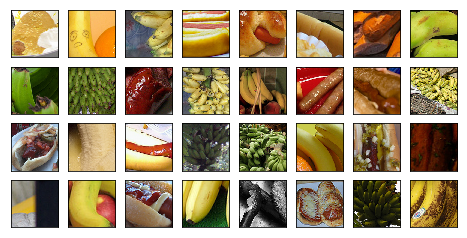

In [3]:
%matplotlib inline
import sys
import utils


train_imgs = gluon.data.vision.ImageFolderDataset(
    'hotdog/train', transform = lambda X, y: transform(X, y, train_augs))
test_imgs = gluon.data.vision.ImageFolderDataset(
    'hotdog/test', transform = lambda X, y: transform(X, y, test_augs))

data = gluon.data.DataLoader(train_imgs, 32, shuffle = True)
for X, _ in data:
    X = X.transpose((0, 2, 3, 1)).clip(0, 255) / 255
    utils.show_images(X, 4, 8)
    break

In [4]:
from mxnet.gluon.model_zoo import vision as models

pretrained_net = models.resnet18_v2(pretrained=True)

In [5]:
pretrained_net

ResNetV2(
  (features): HybridSequential(
    (0): BatchNorm(momentum=0.9, eps=1e-05, fix_gamma=True, axis=1)
    (1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (2): BatchNorm(momentum=0.9, eps=1e-05, fix_gamma=False, axis=1)
    (3): Activation(relu)
    (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
    (5): HybridSequential(
      (0): BasicBlockV2(
        (bn2): BatchNorm(momentum=0.9, eps=1e-05, fix_gamma=False, axis=1)
        (bn1): BatchNorm(momentum=0.9, eps=1e-05, fix_gamma=False, axis=1)
        (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlockV2(
        (bn2): BatchNorm(momentum=0.9, eps=1e-05, fix_gamma=False, axis=1)
        (bn1): BatchNorm(momentum=0.9, eps=1e-05, fix_gamma=False, axis=1)
        (conv2): Conv2D(64 -> 64, kernel_size=(3

In [6]:
from mxnet import init

finetune_net = models.resnet18_v2(classes = 2)
finetune_net.features = pretrained_net.features
finetune_net.classifier.initialize(init.Xavier())

In [7]:
def train(net, ctx, batch_size=64, epochs=10, learning_rate=0.01, wd=0.001):
    train_data = gluon.data.DataLoader(train_imgs, batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_imgs, batch_size)
    
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate':learning_rate, 'wd':wd})
    utils.train(train_data, test_data, net, loss, trainer, ctx, epochs)

In [8]:
ctx = utils.try_all_gpus()
train(finetune_net, ctx)

Start training on  [gpu(0)]
Epoch 0. Loss: 0.395, Train acc 0.84, Test acc 0.93, Time 30.5 sec
Epoch 1. Loss: 0.211, Train acc 0.93, Test acc 0.93, Time 13.0 sec
Epoch 2. Loss: 0.162, Train acc 0.95, Test acc 0.95, Time 13.1 sec
Epoch 3. Loss: 0.128, Train acc 0.95, Test acc 0.95, Time 13.0 sec
Epoch 4. Loss: 0.107, Train acc 0.96, Test acc 0.95, Time 13.0 sec
Epoch 5. Loss: 0.098, Train acc 0.97, Test acc 0.95, Time 13.1 sec
Epoch 6. Loss: 0.083, Train acc 0.97, Test acc 0.96, Time 12.9 sec
Epoch 7. Loss: 0.071, Train acc 0.98, Test acc 0.96, Time 12.7 sec
Epoch 8. Loss: 0.077, Train acc 0.98, Test acc 0.96, Time 12.8 sec
Epoch 9. Loss: 0.060, Train acc 0.98, Test acc 0.96, Time 12.8 sec


In [14]:
import matplotlib.pyplot as plt

def classify_hotdog(net, fname):
    with open(fname, 'rb') as f:
        img = image.imdecode(f.read())
    data, _ = transform(img, -1, test_augs)
    #plt.imshow(data.transpose((1,2,0)).asnumpy()/255)
    data = data.expand_dims(axis = 0)
    out = net(data.as_in_context(ctx[0]))
    pred = int(nd.argmax(out, axis = 1).asscalar())
    prob = out[0][pred].asscalar()
    label = train_imgs.synsets
    return 'With prob=%f, %s'%(prob, label[pred])

In [15]:
classify_hotdog(finetune_net, 'hotdog/test/hotdog/1397.png')

'With prob=2.469935, hotdog'

In [17]:
classify_hotdog(finetune_net, 'hotdog/test/not-hotdog/1238.png')

'With prob=1.058800, not-hotdog'